This is a two-week long homework composed of the following portions:

1. Bond construction 
2. Duration calculation (should be pretty simple!)
3. Using the FRED API to plot the yield/forward/zero curve
4. Using treasury coupon bond prices as of 09/19/2025 to bootstrap spot rates from coupon bonds. 
    Write a small piece comparing that with the zero curve. 
5. From the spot curve in Q4, plot the forward curve and classify the yield shape (is it inverted/normal etc)


For all data collection purposes get the data as of **09/19/2025**.

# Question 1

Constructure hypothetical treasury par bond of a given time to maturity (in years) with given yield that pays semiannual coupons. Just define the functions

In [1]:
pip install fredapi

  Obtaining dependency information for fredapi from https://files.pythonhosted.org/packages/73/64/1db43417cf7ed430f104a347126b5260a1724ee9a1b7d0b1622262c9c4df/fredapi-0.5.2-py3-none-any.whl.metadata
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fredapi import Fred
from scipy.optimize import newton
import math



In [3]:
# ------------------- Parameters -------------------
# T = (float) Time to maturity
# y = (float) Yield
# freq = (int) Frequency of payments(Mentioned that it is TBond with semiannual coupons)
# c = (float) Coupon rate = yield(for a par bond)
# par = 100.0

# Bond present value 
def tbond_pv(y, T, freq=2):

    cash_flows = {}
    par = 100
    n_periods = T*freq
    for i in range(1, n_periods+1): 
        if i<(freq*T):
            cash_flows[i] = ((y * par) / freq)*np.exp(-y*(i/freq))
        elif(i==n_periods):
            cash_flows[i] = ((y * par) / freq + par)*np.exp(-y*(i/freq))                #Final cashflow = Coupon payment + Par

    return sum(cash_flows.values())

# Question 2

Calculate its' duration

In [4]:
# Bond duration at inception
def tbond_duration(y, T, freq=2):
    par = 100
    n_periods = T*freq
    cashflows = tbond_cashflows(y, T, freq=2)
    pv, duration = 0, 0


    # Calculating the bond duration using a loop
    for i in range(1, n_periods+1): 
        duration += cashflows[i]*(i/freq)*np.exp(-y*(i/freq))
        pv += cashflows[i]*np.exp(-y*(i/freq))

    return (duration/pv)

# Question 3 
Use the FRED API to get the yields by maturity.  Plot the yield curve, forward curve and zero curve. 


In [5]:
# FRED series IDs for Treasury yields by maturity 
series_ids = { '3M': 'DGS3MO', '6M': 'DGS6MO', '1Y': 'DGS1', '2Y':
 'DGS2', '3Y': 'DGS3', '5Y': 'DGS5', '7Y': 'DGS7', '10Y': 'DGS10',
  '20Y': 'DGS20', '30Y': 'DGS30' }

# Connecting to FRED via an AKI key
fred = Fred(api_key='d5eb5f6ce82f36b16e7f11dee4e6d632')

# Getting the latest yield data
yields  =  {label: fred.get_series(series_ids).dropna().iloc[-1] 
            for label, series_ids in series_ids.items()}

#Converting to a dataframe and resetting the index
yields_df = pd.DataFrame(list(yields.items()), columns = ['Maturity', 'Yields'])

# Sorting the DataFrame by maturity (for clarity)
maturity_order = ['3M','6M','1Y','2Y','3Y','5Y','7Y','10Y','20Y','30Y']
yields_df['Maturity'] = pd.Categorical(yields_df['Maturity'], categories=maturity_order, ordered=True)
yields_df = yields_df.sort_values('Maturity').reset_index(drop=True)

print(yields_df)

  Maturity  Yields
0       3M    4.02
1       6M    3.83
2       1Y    3.68
3       2Y    3.60
4       3Y    3.61
5       5Y    3.74
6       7Y    3.93
7      10Y    4.16
8      20Y    4.71
9      30Y    4.73


In [6]:
# Convert maturities into years
yields_df['T_years'] = yields_df['Maturity'].apply(
    lambda x: int(x.replace('M', '')) / 12 if 'M' in x else int(x.replace('Y', ''))
)

# Convert the yields to percentages
yields_df['Yields'] = yields_df['Yields']/100

yields_df.head()

,Maturity,Yields,T_years
0,3M,0.0402,0.25
1,6M,0.0383,0.50
2,1Y,0.0368,1.00
3,2Y,0.0360,2.00
4,3Y,0.0361,3.00


In [7]:
yields_df['Zero'] = np.nan
yields_df['Forward'] = np.nan

DFs = []
for T, R in zip(yields_df['T_years'], yields_df['Yields']):
    DF = 1.0 / ((1.0 + R) ** T)  # annual compounding
    DFs.append(DF)

# Computing zero rates
yields_df['Zero'] = [-math.log(DF)/T for DF, T in zip(DFs, yields_df['T_years'])]

# Computing forward rates
fwds = [np.nan]  # first forward is undefined
for i in range(1, len(yields_df)):
    t1, t2 = yields_df.loc[i-1, 'T_years'], yields_df.loc[i, 'T_years']
    z1, z2 = yields_df.loc[i-1, 'Zero'], yields_df.loc[i, 'Zero']
    fwd = (z2 * t2 - z1 * t1) / (t2 - t1)
    fwds.append(fwd)

yields_df['Forward'] = fwds
print(yields_df)

  Maturity  Yields T_years      Zero   Forward
0       3M  0.0402    0.25  0.039413       NaN
1       6M  0.0383    0.50  0.037585  0.035757
2       1Y  0.0368    1.00  0.036139  0.034693
3       2Y  0.0360    2.00  0.035367  0.034595
4       3Y  0.0361    3.00  0.035464  0.035657
5       5Y  0.0374    5.00  0.036718  0.038598
6       7Y  0.0393    7.00  0.038547  0.043122
7      10Y  0.0416   10.00  0.040758  0.045916
8      20Y  0.0471   20.00  0.046024  0.051291
9      30Y  0.0473   30.00  0.046215  0.046597


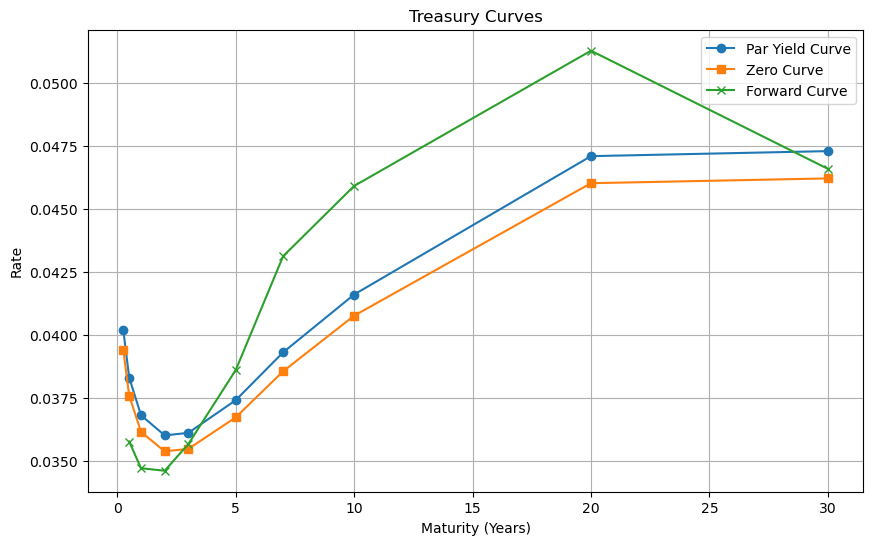

In [8]:
# Plotting the curves
plt.figure(figsize=(10,6))

plt.plot(yields_df['T_years'], yields_df['Yields'], 'o-', label='Par Yield Curve')
plt.plot(yields_df['T_years'], yields_df['Zero'], 's-', label='Zero Curve')
plt.plot(yields_df['T_years'], yields_df['Forward'], 'x-', label='Forward Curve')

# Labels and title
plt.xlabel("Maturity (Years)")
plt.ylabel("Rate")
plt.title("Treasury Curves")
plt.grid(True)
plt.legend()
plt.show()

# Question 4

Bootstrap spot Rates from coupon bonds - use the FRED API or Bloomberg to get the treasury prices/yields - do this till the 30Y. 

In [9]:
from scipy.interpolate import interp1d

interp_func = interp1d(yields_df['T_years'], yields_df['Yields'], kind='linear')        # interp1d function: returns a new function that you can use to find y-values for new, arbitrary x-values
max_T = int(yields_df['T_years'].max())                                                 # looking for the max Maturity in the dataset
coupon_times = np.arange(0.5, max_T + 0.5, 0.5)                                         # creating coupon times array


# Building a new dataframe with interpolated yields
interp_df = pd.DataFrame({
    'T_years': coupon_times,
    'Yields': interp_func(coupon_times)
})
interp_df['Spot'] = np.nan

par = 100
freq = 2
# Bootstrapping on the full coupn grid
for i, row in interp_df.iterrows():
    T = row['T_years']
    y = row['Yields']
    c = (par * y) / freq
    n = int(T * freq)

    if T <= 1:
        z_i = y
    else:
        pv_coupons = 0
        for k in range(1, n):
            t_k = k / freq
            z_k = interp_df.loc[interp_df['T_years']==t_k, 'Spot'].values[0]
            pv_coupons += c * np.exp(-z_k * t_k)

        z_i = -(1/T) * np.log((par - pv_coupons) / (par + c))

    interp_df.loc[i, 'Spot'] = z_i


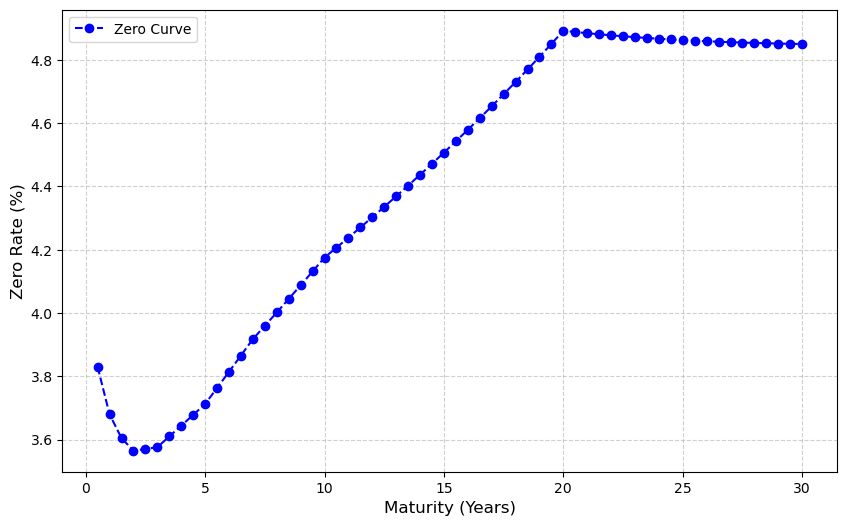

In [10]:
#Plotting the Zero curve
plt.figure(figsize=(10,6))
plt.plot(interp_df['T_years'], interp_df['Spot']*100, label='Zero Curve', linestyle='--', color = 'blue', marker='o')
plt.xlabel("Maturity (Years)", fontsize=12)
plt.ylabel("Zero Rate (%)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()

# Question 5

Calculate the 1 year forward rates from 1Y - 30Y (so 2Y1Y forward, 3Y1Y forward etc.). Plot the forward curve and classify the shape of it (inverted/normal etc.) Explain what that means!

In [11]:
# COmputing Forward rates
interp_df['Forward'] = np.nan

for i in range(1, len(interp_df)):
    t1 = interp_df.loc[i-1, 'T_years']
    t2 = interp_df.loc[i, 'T_years']
    z1 = interp_df.loc[i-1, 'Spot']
    z2 = interp_df.loc[i, 'Spot']

    f = (z2*t2 - z1*t1) / (t2 - t1)
    interp_df.loc[i, 'Forward'] = f

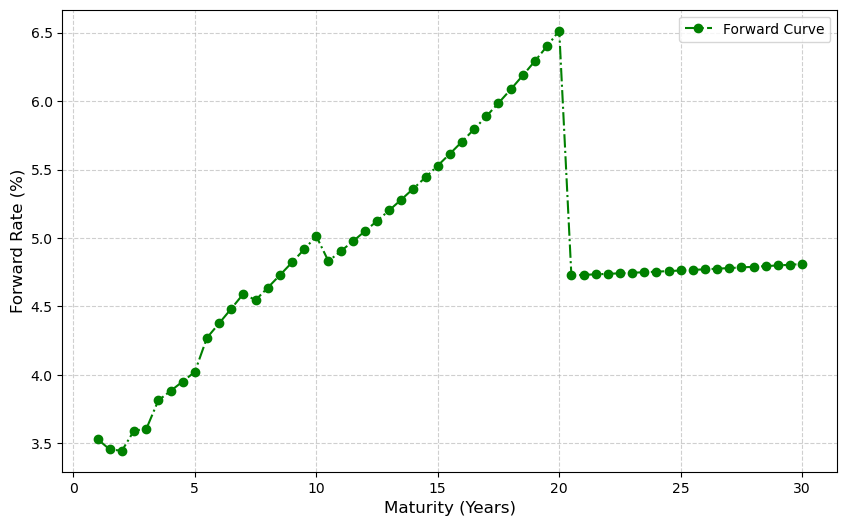

In [12]:
# Plotting the Forward rates
plt.figure(figsize=(10,6))
plt.plot(interp_df['T_years'][1:], interp_df['Forward'][1:]*100, linestyle='-.', label='Forward Curve', color = 'green', marker ='o' )
plt.xlabel("Maturity (Years)", fontsize=12)
plt.ylabel("Forward Rate (%)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()